# check model embeddings - cosine similarity/l2 norm

In [1]:
from dataloader import *
from model import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd

/home/jovyan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_data_folder = "/home/jovyan/face-recognition-model-development/lfw_dataset/lfw_face_processed.csv"
input_dim = 512
num_classes = 902

# load data

input_data_folder="/home/jovyan/face-recognition-model-development/lfw_dataset/lfw_face_processed.csv"
df = pd.read_csv(input_data_folder)
haidi_df = df[df.person_name=='haidi_azaman']
haidi_df.head()

,image_path,person_name,bbox,split_type,label
7606,/home/jovyan/face-recognition-model-developmen...,haidi_azaman,"[180, 265, 715, 1052]",train,901
7607,/home/jovyan/face-recognition-model-developmen...,haidi_azaman,"[178, 287, 712, 1030]",train,901
7608,/home/jovyan/face-recognition-model-developmen...,haidi_azaman,"[130, 319, 778, 1183]",train,901
7609,/home/jovyan/face-recognition-model-developmen...,haidi_azaman,"[228, 324, 765, 1063]",train,901
7610,/home/jovyan/face-recognition-model-developmen...,haidi_azaman,"[239, 267, 780, 982]",train,901


In [3]:
def load_image(input_param):
    expand_ratio = 0
    image = cv2.cvtColor(cv2.imread(input_param['image_path']), cv2.COLOR_BGR2RGB)
    l, t, r, b = input_param['bbox']
    w, h = r - l, b - t
    l, r = max(0, l - int(expand_ratio * w / 2)), min(image.shape[1] - 1, r + int(expand_ratio * w / 2))
    t, b = max(0, t - int(expand_ratio * h / 2)), min(image.shape[0] - 1, b + int(expand_ratio * h / 2))
    input_dim = input_param['input_dim']
    image = cv2.resize(image[t:b, l:r], (input_dim, input_dim))
    return image

       
def apply_input_transforms(image):
    transforms=Compose([
        ToTensor()
    ])
    image=transforms(image)
    return image 

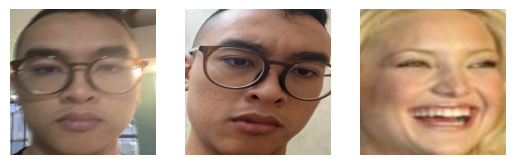

In [4]:
input_param1 = {
    'image_path':haidi_df.loc[7610,'image_path'],
    'bbox':eval(haidi_df.loc[7610,'bbox']),
    'input_dim':512
}
x1=load_image(input_param1)
x1=apply_input_transforms(x1)

input_param2 = {
    'image_path':haidi_df.loc[7609,'image_path'],
    'bbox':eval(haidi_df.loc[7609,'bbox']),
    'input_dim':512
}
x2=load_image(input_param2)
x2=apply_input_transforms(x2)


input_param3 = {
    'image_path':df.loc[0,'image_path'],
    'bbox':eval(df.loc[0,'bbox']),
    'input_dim':512
}
x3=load_image(input_param3)
x3=apply_input_transforms(x3)

plt.subplot(1,3,1)
plt.imshow(x1.permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(x2.permute(1,2,0))
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(x3.permute(1,2,0))
plt.axis('off')
plt.show()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x1=x1.to(device)
x2=x2.to(device)
x3=x3.to(device)

In [5]:
# model 1 - pretrained model before finetuning

model1 = FaceNet(num_classes=num_classes,pretrained='vggface2')
model1 = model1.to(device)
_ = model1.eval()

In [6]:
# model 2 - load best model after finetuning

load_model = '/home/jovyan/face-recognition-model-development/train/result/v1.0.0/weights/best_model.pt'
num_classes = 902 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model2 = FaceNet(num_classes=num_classes,pretrained='vggface2')
model2 = model2.to(device)
if load_model:
    model2.load_state_dict(torch.load(os.path.join('./result', load_model), map_location = device))
    _ = model2.eval()

In [9]:
# define similarity functions

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similarity_score(x1,x2,method='cosine'):
    if method=='cosine':
        return cosine_similarity(x1,x2).item()
    elif method=='l2norm':
        return np.linalg.norm(x1-x2)

In [11]:
# strip the last layer to only use the embeddings to do face matching in the app

with torch.no_grad():
    embeddings11 = model1.backbone.get_embeddings(x1.unsqueeze(0)).detach().cpu()
    embeddings12 = model1.backbone.get_embeddings(x2.unsqueeze(0)).detach().cpu()
    embeddings13 = model1.backbone.get_embeddings(x3.unsqueeze(0)).detach().cpu()
    
    embeddings21 = model2.backbone.get_embeddings(x1.unsqueeze(0)).detach().cpu()
    embeddings22 = model2.backbone.get_embeddings(x2.unsqueeze(0)).detach().cpu()
    embeddings23 = model2.backbone.get_embeddings(x3.unsqueeze(0)).detach().cpu()
    
print("pretrained model WITHOUT finetuning")
print(f"cosine similarity score: {get_similarity_score(embeddings11,embeddings12,'cosine')}")
print(f"cosine similarity score: {get_similarity_score(embeddings11,embeddings13,'cosine')}")


print()   
print("pretrained model AFTER finetuning")
print(f"cosine similarity score: {get_similarity_score(embeddings21,embeddings22,'cosine')}")
print(f"cosine similarity score: {get_similarity_score(embeddings21,embeddings23,'cosine')}")

pretrained model WITHOUT finetuning
cosine similarity score: 0.9353532195091248
cosine similarity score: 0.5654318928718567

pretrained model AFTER finetuning
cosine similarity score: 0.869266152381897
cosine similarity score: 0.21744409203529358
